In [11]:
# Cell 1: Import and Setup
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import required modules
from src.data.dataset import ChestXrayDataset, create_data_splits
from src.data.dataloader import create_rtx3060_dataloaders
from src.models.densenet121_enhanced import DenseNet121MultiLabelEnhanced

print("✅ Imports complete")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

✅ Imports complete
🚀 Device: cuda


In [12]:
# Cell 2: Load Model and Training Data
print("📥 Loading saved model and training data...")

# Load saved model
model_path = "../models/saved_models/enhanced_densenet121/model.pth"
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Create model architecture
model = DenseNet121MultiLabelEnhanced(
    num_classes=checkpoint['num_classes'],
    pretrained=False,
    dropout_rate=checkpoint['dropout_rate'],
    use_attention=checkpoint['use_attention'],
    feature_fusion=checkpoint['feature_fusion']
)

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print("✅ Model loaded successfully!")
print(f"   Architecture: {checkpoint['architecture']}")
print(f"   Classes: {checkpoint['num_classes']}")
print(f"   Image size: {checkpoint['image_size']}")
print(f"   Attention: {checkpoint['use_attention']}")

# Load training history
history_df = pd.read_csv("../models/saved_models/enhanced_densenet121/training_history.csv")
training_metrics = np.load("../models/saved_models/enhanced_densenet121/training_metrics.npz")

print("✅ Training data loaded!")
print(f"   Epochs trained: {len(history_df)}")
print(f"   Best AUC: {history_df['val_auc'].max():.4f}")

📥 Loading saved model and training data...
✅ Enhanced DenseNet121 Multi-Label Model created:
   Classes: 15
   Pretrained: False
   Dropout: 0.4
   Attention: True
   Feature Fusion: True
✅ Model loaded successfully!
   Architecture: DenseNet121Enhanced
   Classes: 15
   Image size: 448
   Attention: True
✅ Training data loaded!
   Epochs trained: 20
   Best AUC: 0.7675


In [13]:
# Cell 3: Load Test Data
print("📊 Loading test dataset...")

# Load dataset
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # Update path
data_entry_path = BASE_PATH / "Data_Entry_2017.csv"
df = pd.read_csv(data_entry_path)

# Create image mapping
image_mapping = {}
for main_folder in sorted(BASE_PATH.iterdir()):
    if main_folder.is_dir() and main_folder.name.startswith('images_'):
        images_subfolder = main_folder / 'images'
        if images_subfolder.exists():
            for img_file in images_subfolder.glob("*.png"):
                image_name = img_file.name
                if image_name not in image_mapping:
                    image_mapping[image_name] = img_file

# Create data splits (same as training)
train_df, val_df, test_df = create_data_splits(df, test_size=0.15, val_size=0.10, random_seed=42)

# Create test dataset
test_dataset = ChestXrayDataset(
    df=test_df,
    image_mapping=image_mapping,
    image_size=checkpoint['image_size'],
    is_training=False
)

# Create test dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ Test data loaded!")
print(f"   Test samples: {len(test_dataset):,}")
print(f"   Test batches: {len(test_loader)}")

📊 Loading test dataset...
Patient-level data splits:
  Train: 83,847 images from 23,105 patients (74.8%)
  Val:   11,550 images from 3,080 patients (10.3%)
  Test:  16,723 images from 4,620 patients (14.9%)
✅ No patient overlap verified - clean splits!
Dataset created with 16723 samples
Training mode: False
Image size: 448x448

Label matrix created: (16723, 15)
Positive samples per class:
  No Finding...............   9018
  Atelectasis..............   1691
  Cardiomegaly.............    426
  Effusion.................   1935
  Infiltration.............   2941
  Mass.....................    835
  Nodule...................    930
  Pneumonia................    220
  Pneumothorax.............    810
  Consolidation............    692
  Edema....................    333
  Emphysema................    417
  Fibrosis.................    281
  Pleural_Thickening.......    497
  Hernia...................     43
Transforms created for validation
✅ Test data loaded!
   Test samples: 16,723
   Te

In [14]:
# Cell 4: Test Model on Test Set
print("🧪 Running model evaluation on test set...")

model.eval()
all_predictions = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for images, labels, metadata in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward pass
        logits = model(images)
        probabilities = torch.sigmoid(logits)
        
        # Store results
        all_predictions.append(probabilities.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate results
test_predictions = np.concatenate(all_predictions, axis=0)
test_labels = np.concatenate(all_labels, axis=0)

print(f"✅ Testing complete!")
print(f"   Samples tested: {len(test_predictions):,}")

🧪 Running model evaluation on test set...


Testing: 100%|█████████████████████████████████████████████████████████████████████| 1046/1046 [02:16<00:00,  7.64it/s]

✅ Testing complete!
   Samples tested: 16,723


In [15]:
# Cell 5: Calculate Comprehensive Test Metrics
print("📊 Calculating test metrics...")

# Disease classes
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

# Calculate per-class metrics
test_aucs = []
test_aps = []

print(f"\n{'Disease':<20} {'Test AUC':<10} {'Test AP':<10}")
print("-" * 40)

for i, disease in enumerate(disease_classes):
    y_true = test_labels[:, i]
    y_pred = test_predictions[:, i]
    
    if y_true.sum() > 0 and (1 - y_true).sum() > 0:
        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
    else:
        auc = 0.5
        ap = 0.0
    
    test_aucs.append(auc)
    test_aps.append(ap)
    
    print(f"{disease:<20} {auc:<10.3f} {ap:<10.3f}")

# Calculate mean metrics
mean_test_auc = np.mean([auc for auc in test_aucs if auc > 0])
mean_test_ap = np.mean([ap for ap in test_aps if ap > 0])

print("-" * 40)
print(f"{'MEAN PERFORMANCE':<20} {mean_test_auc:<10.3f} {mean_test_ap:<10.3f}")

# Compare with validation performance
best_val_auc = history_df['val_auc'].max()
print(f"\n🔍 Performance Comparison:")
print(f"   Best Validation AUC: {best_val_auc:.4f}")
print(f"   Test AUC: {mean_test_auc:.4f}")
print(f"   Generalization Gap: {best_val_auc - mean_test_auc:.4f}")

📊 Calculating test metrics...

Disease              Test AUC   Test AP   
----------------------------------------
No Finding           0.736      0.743     
Atelectasis          0.726      0.224     
Cardiomegaly         0.889      0.249     
Effusion             0.851      0.455     
Infiltration         0.646      0.292     
Mass                 0.729      0.191     
Nodule               0.589      0.084     
Pneumonia            0.617      0.022     
Pneumothorax         0.822      0.274     
Consolidation        0.763      0.129     
Edema                0.876      0.147     
Emphysema            0.898      0.382     
Fibrosis             0.693      0.040     
Pleural_Thickening   0.741      0.107     
Hernia               0.813      0.270     
----------------------------------------
MEAN PERFORMANCE     0.759      0.241     

🔍 Performance Comparison:
   Best Validation AUC: 0.7675
   Test AUC: 0.7594
   Generalization Gap: 0.0081


📈 Creating comprehensive visualization...


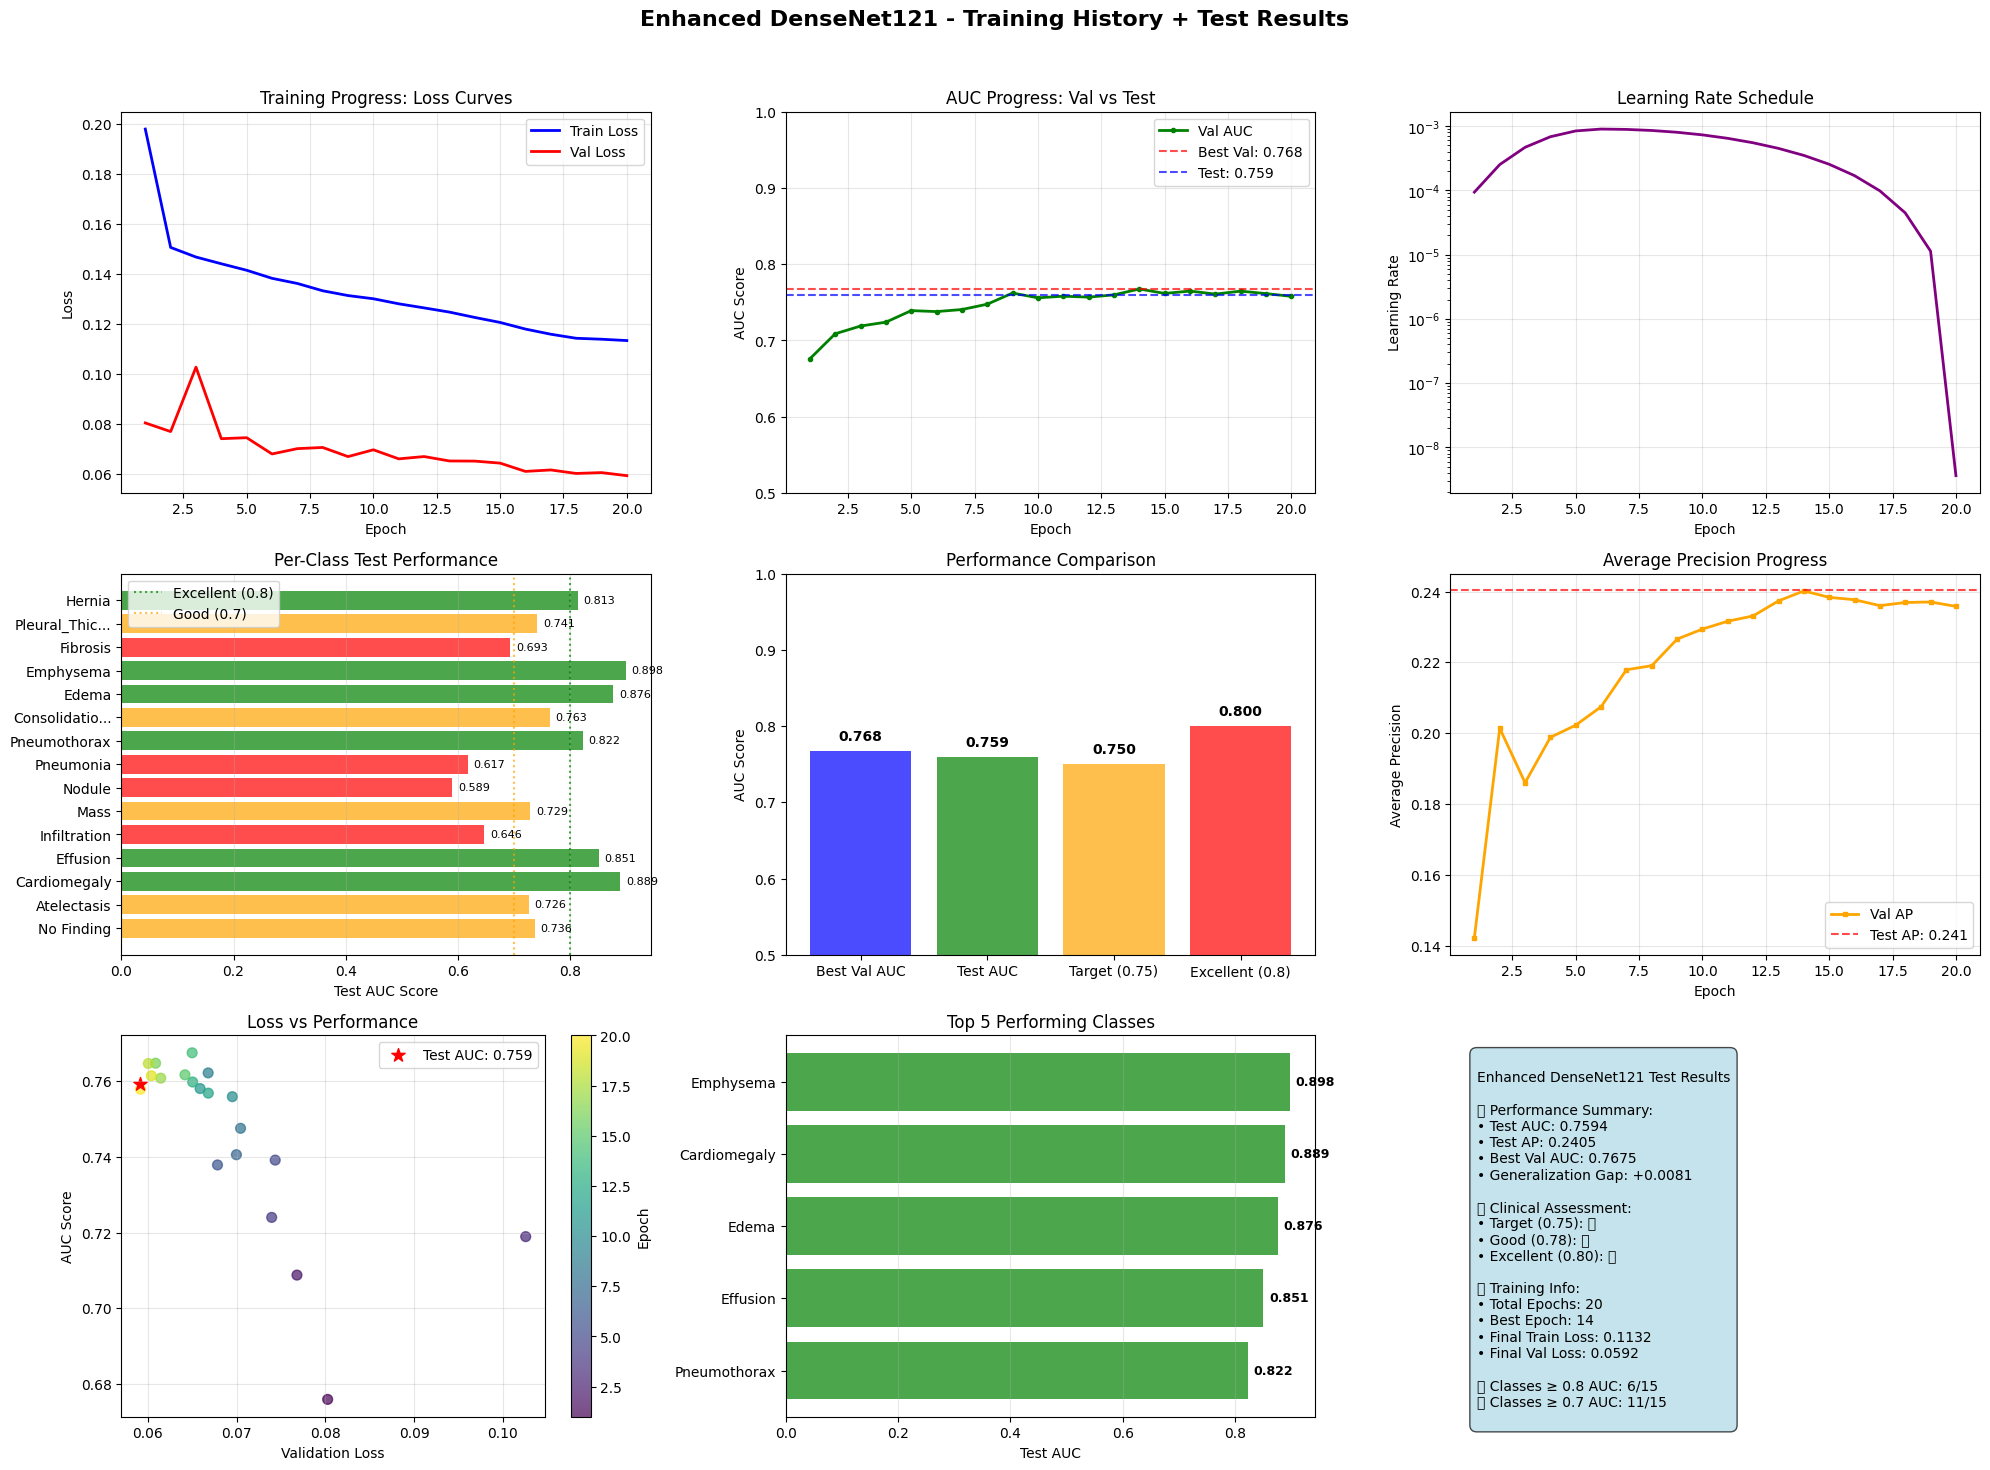

✅ Comprehensive analysis complete!
📊 Plot saved: ../results/Enhanced_Densenet121/enhanced_model_complete_analysis.png.png


In [17]:
# Cell 6: Training History + Test Results Visualization
print("📈 Creating comprehensive visualization...")

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Enhanced DenseNet121 - Training History + Test Results', fontsize=16, fontweight='bold')

epochs = range(1, len(history_df) + 1)

# 1. Training and Validation Loss
ax1 = axes[0, 0]
ax1.plot(epochs, history_df['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax1.plot(epochs, history_df['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Progress: Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. AUC Progress
ax2 = axes[0, 1]
ax2.plot(epochs, history_df['val_auc'], 'g-', linewidth=2, marker='o', markersize=3, label='Val AUC')
ax2.axhline(y=best_val_auc, color='red', linestyle='--', alpha=0.7, label=f'Best Val: {best_val_auc:.3f}')
ax2.axhline(y=mean_test_auc, color='blue', linestyle='--', alpha=0.7, label=f'Test: {mean_test_auc:.3f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC Score')
ax2.set_title('AUC Progress: Val vs Test')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.5, 1.0])

# 3. Learning Rate Schedule
ax3 = axes[0, 2]
ax3.plot(epochs, history_df['learning_rate'], 'purple', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Per-class Test AUC (Bar plot)
ax4 = axes[1, 0]
colors = ['green' if auc >= 0.8 else 'orange' if auc >= 0.7 else 'red' for auc in test_aucs]
bars = ax4.barh(range(len(disease_classes)), test_aucs, color=colors, alpha=0.7)
ax4.set_yticks(range(len(disease_classes)))
ax4.set_yticklabels([d[:12] + '...' if len(d) > 12 else d for d in disease_classes])
ax4.set_xlabel('Test AUC Score')
ax4.set_title('Per-Class Test Performance')
ax4.axvline(x=0.8, color='green', linestyle=':', alpha=0.7, label='Excellent (0.8)')
ax4.axvline(x=0.7, color='orange', linestyle=':', alpha=0.7, label='Good (0.7)')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

# Add AUC values on bars
for i, (bar, auc) in enumerate(zip(bars, test_aucs)):
    ax4.text(auc + 0.01, bar.get_y() + bar.get_height()/2, f'{auc:.3f}', 
             va='center', fontsize=8)

# 5. Training vs Test Comparison
ax5 = axes[1, 1]
comparison_data = {
    'Best Val AUC': best_val_auc,
    'Test AUC': mean_test_auc,
    'Target (0.75)': 0.75,
    'Excellent (0.8)': 0.8
}
bars = ax5.bar(comparison_data.keys(), comparison_data.values(), 
               color=['blue', 'green', 'orange', 'red'], alpha=0.7)
ax5.set_ylabel('AUC Score')
ax5.set_title('Performance Comparison')
ax5.set_ylim(0.5, 1.0)

# Add value labels on bars
for bar, value in zip(bars, comparison_data.values()):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. Average Precision Progress
ax6 = axes[1, 2]
ax6.plot(epochs, history_df['val_ap'], 'orange', linewidth=2, marker='s', markersize=3, label='Val AP')
ax6.axhline(y=mean_test_ap, color='red', linestyle='--', alpha=0.7, label=f'Test AP: {mean_test_ap:.3f}')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Average Precision')
ax6.set_title('Average Precision Progress')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Loss vs AUC Relationship
ax7 = axes[2, 0]
scatter = ax7.scatter(history_df['val_loss'], history_df['val_auc'], 
                     c=epochs, cmap='viridis', alpha=0.7, s=50)
# FIX: Add a dummy validation loss for test AUC point
ax7.scatter([history_df['val_loss'].iloc[-1]], [mean_test_auc], c='red', s=100, marker='*', 
           label=f'Test AUC: {mean_test_auc:.3f}')
ax7.set_xlabel('Validation Loss')
ax7.set_ylabel('AUC Score')
ax7.set_title('Loss vs Performance')
ax7.legend()
ax7.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax7, label='Epoch')

# 8. Top 5 Best Performing Classes
ax8 = axes[2, 1]
top_5_indices = np.argsort(test_aucs)[-5:]
top_5_diseases = [disease_classes[i] for i in top_5_indices]
top_5_aucs = [test_aucs[i] for i in top_5_indices]

ax8.barh(range(5), top_5_aucs, color='green', alpha=0.7)
ax8.set_yticks(range(5))
ax8.set_yticklabels(top_5_diseases)
ax8.set_xlabel('Test AUC')
ax8.set_title('Top 5 Performing Classes')
ax8.grid(axis='x', alpha=0.3)

# Add AUC values
for i, auc in enumerate(top_5_aucs):
    ax8.text(auc + 0.01, i, f'{auc:.3f}', va='center', fontsize=9, fontweight='bold')

# 9. Model Summary
ax9 = axes[2, 2]
ax9.axis('off')

summary_text = f"""
Enhanced DenseNet121 Test Results

📊 Performance Summary:
• Test AUC: {mean_test_auc:.4f}
• Test AP: {mean_test_ap:.4f}
• Best Val AUC: {best_val_auc:.4f}
• Generalization Gap: {best_val_auc - mean_test_auc:+.4f}

🎯 Clinical Assessment:
• Target (0.75): {'✅' if mean_test_auc >= 0.75 else '❌'}
• Good (0.78): {'✅' if mean_test_auc >= 0.78 else '❌'}
• Excellent (0.80): {'✅' if mean_test_auc >= 0.80 else '❌'}

📈 Training Info:
• Total Epochs: {len(epochs)}
• Best Epoch: {history_df['val_auc'].idxmax() + 1}
• Final Train Loss: {history_df['train_loss'].iloc[-1]:.4f}
• Final Val Loss: {history_df['val_loss'].iloc[-1]:.4f}

🏥 Classes ≥ 0.8 AUC: {sum(1 for auc in test_aucs if auc >= 0.8)}/15
🎪 Classes ≥ 0.7 AUC: {sum(1 for auc in test_aucs if auc >= 0.7)}/15
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("../results/Enhanced_Densenet121/enhanced_model_complete_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive analysis complete!")
print(f"📊 Plot saved: ../results/Enhanced_Densenet121/enhanced_model_complete_analysis.png.png")

🔳 Creating combined confusion matrix for all 15 classes...


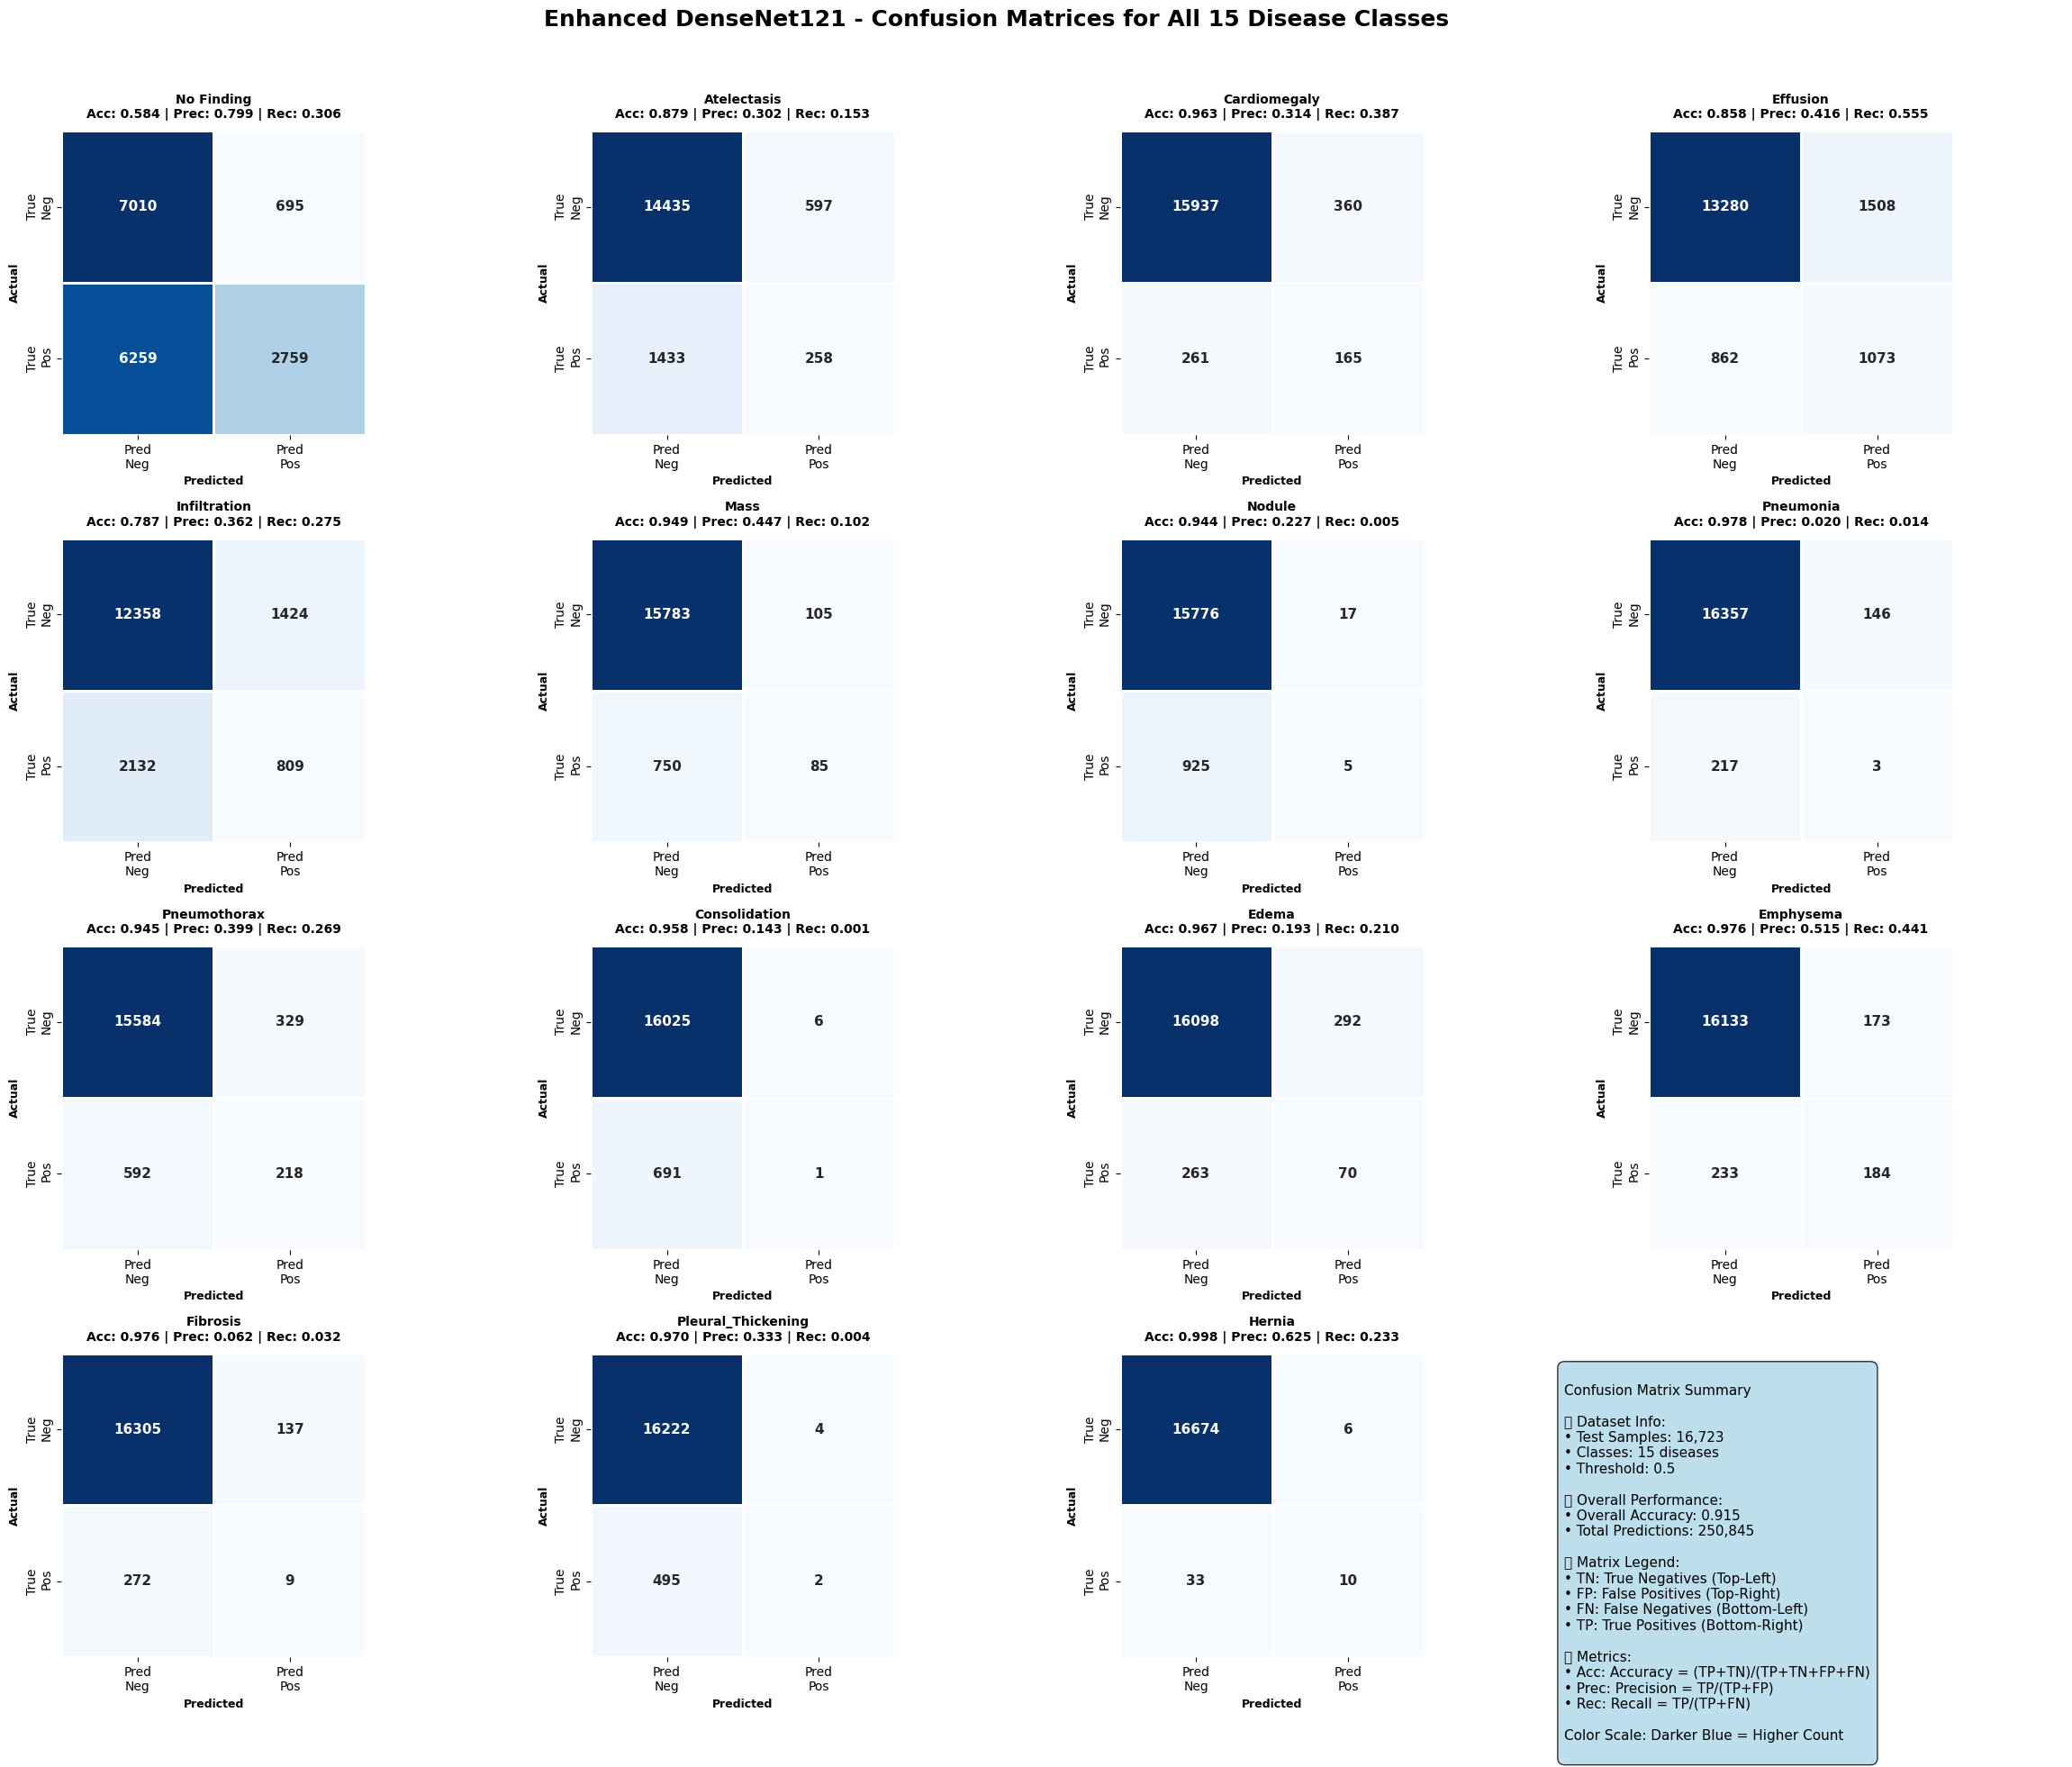

✅ All 15 confusion matrices saved!
📁 File: ../results/Enhanced_Densenet121/enhanced_confusion_matrix_all_classes.png

📊 Detailed Statistics:
Disease              TP    TN     FP    FN    Acc    Prec   Rec   
----------------------------------------------------------------------
No Finding           2759  7010   695   6259  0.584  0.799  0.306 
Atelectasis          258   14435  597   1433  0.879  0.302  0.153 
Cardiomegaly         165   15937  360   261   0.963  0.314  0.387 
Effusion             1073  13280  1508  862   0.858  0.416  0.555 
Infiltration         809   12358  1424  2132  0.787  0.362  0.275 
Mass                 85    15783  105   750   0.949  0.447  0.102 
Nodule               5     15776  17    925   0.944  0.227  0.005 
Pneumonia            3     16357  146   217   0.978  0.020  0.014 
Pneumothorax         218   15584  329   592   0.945  0.399  0.269 
Consolidation        1     16025  6     691   0.958  0.143  0.001 
Edema                70    16098  292   263   0.967

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert predictions to binary (threshold = 0.5)
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)
binary_labels = test_labels.astype(int)

# Disease classes
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print("🔳 Creating combined confusion matrix for all 15 classes...")

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(24, 20))
fig.suptitle('Enhanced DenseNet121 - Confusion Matrices for All 15 Disease Classes', 
             fontsize=18, fontweight='bold', y=0.98)

# Create confusion matrix for each class
for idx, disease in enumerate(disease_classes):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    # Get true and predicted labels for this class
    y_true = binary_labels[:, idx]
    y_pred = binary_predictions[:, idx]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Handle edge cases where only one class exists
    if cm.shape == (1, 1):
        if y_true.sum() == 0:  # All negatives
            cm = np.array([[cm[0,0], 0], [0, 0]])
        else:  # All positives  
            cm = np.array([[0, 0], [0, cm[0,0]]])
    elif cm.shape == (2, 1):  # Only negatives predicted
        cm = np.array([[cm[0,0], cm[1,0]], [0, 0]])
    elif cm.shape == (1, 2):  # Only positives predicted
        cm = np.array([[cm[0,0], 0], [cm[0,1], 0]])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred\nNeg', 'Pred\nPos'], 
                yticklabels=['True\nNeg', 'True\nPos'],
                cbar=False, square=True, linewidths=1.0,
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Set title with disease name and key metrics
    ax.set_title(f'{disease}\nAcc: {accuracy:.3f} | Prec: {precision:.3f} | Rec: {recall:.3f}', 
                fontsize=10, fontweight='bold', pad=10)
    
    # Style the axes
    ax.set_xlabel('Predicted', fontsize=9, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=9, fontweight='bold')

# Remove empty subplot
axes[3, 3].axis('off')

# Add legend/summary in empty subplot
ax_legend = axes[3, 3]
ax_legend.axis('off')

# Calculate overall statistics
total_tp = sum(cm[1,1] for cm in [confusion_matrix(binary_labels[:, i], binary_predictions[:, i]) 
                                  for i in range(15) if binary_labels[:, i].sum() > 0])
total_samples = len(test_predictions) * 15
overall_accuracy = (binary_predictions == binary_labels).mean()

summary_text = f"""
Confusion Matrix Summary

📊 Dataset Info:
• Test Samples: {len(test_predictions):,}
• Classes: 15 diseases
• Threshold: {threshold}

📈 Overall Performance:
• Overall Accuracy: {overall_accuracy:.3f}
• Total Predictions: {total_samples:,}

🎯 Matrix Legend:
• TN: True Negatives (Top-Left)
• FP: False Positives (Top-Right)  
• FN: False Negatives (Bottom-Left)
• TP: True Positives (Bottom-Right)

📊 Metrics:
• Acc: Accuracy = (TP+TN)/(TP+TN+FP+FN)
• Prec: Precision = TP/(TP+FP)
• Rec: Recall = TP/(TP+FN)

Color Scale: Darker Blue = Higher Count
"""

ax_legend.text(0.05, 0.95, summary_text, transform=ax_legend.transAxes, 
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("../results/Enhanced_Densenet121/enhanced_confusion_matrix_all_classes.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ All 15 confusion matrices saved!")
print(f"📁 File: ../results/Enhanced_Densenet121/enhanced_confusion_matrix_all_classes.png")

# Print detailed statistics
print(f"\n📊 Detailed Statistics:")
print(f"{'Disease':<20} {'TP':<5} {'TN':<6} {'FP':<5} {'FN':<5} {'Acc':<6} {'Prec':<6} {'Rec':<6}")
print("-" * 70)

for idx, disease in enumerate(disease_classes):
    y_true = binary_labels[:, idx]
    y_pred = binary_predictions[:, idx]
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Handle different matrix shapes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        if y_true.sum() == 0:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0,0]
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
    
    # Calculate metrics
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"{disease:<20} {tp:<5} {tn:<6} {fp:<5} {fn:<5} {accuracy:<6.3f} {precision:<6.3f} {recall:<6.3f}")

print(f"\n🎉 Enhanced confusion matrix analysis complete!")

🔳 Creating 15×15 multi-label confusion matrix...
📊 Creating co-occurrence confusion matrix...


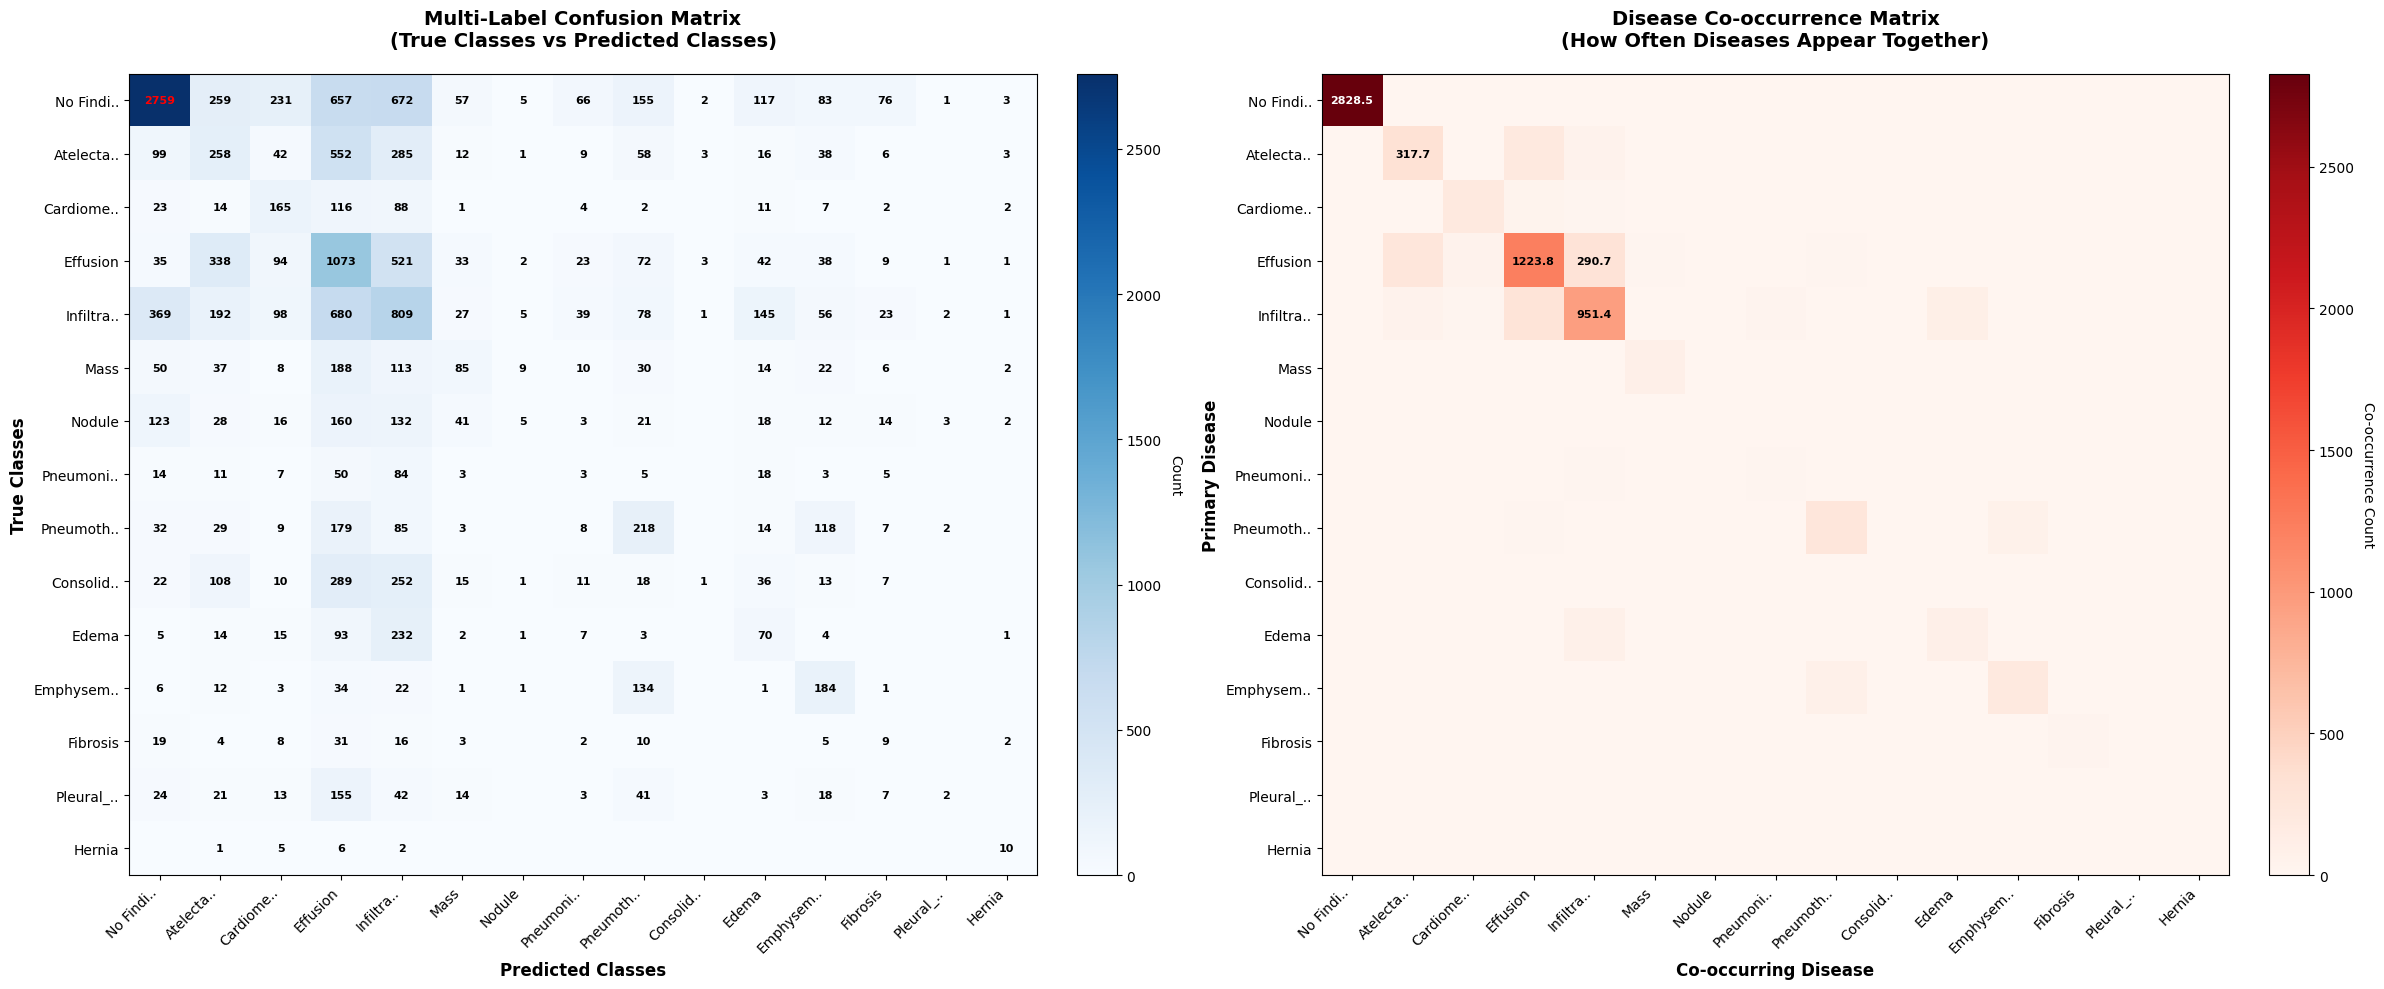

📊 Creating simple 15×15 heatmap...


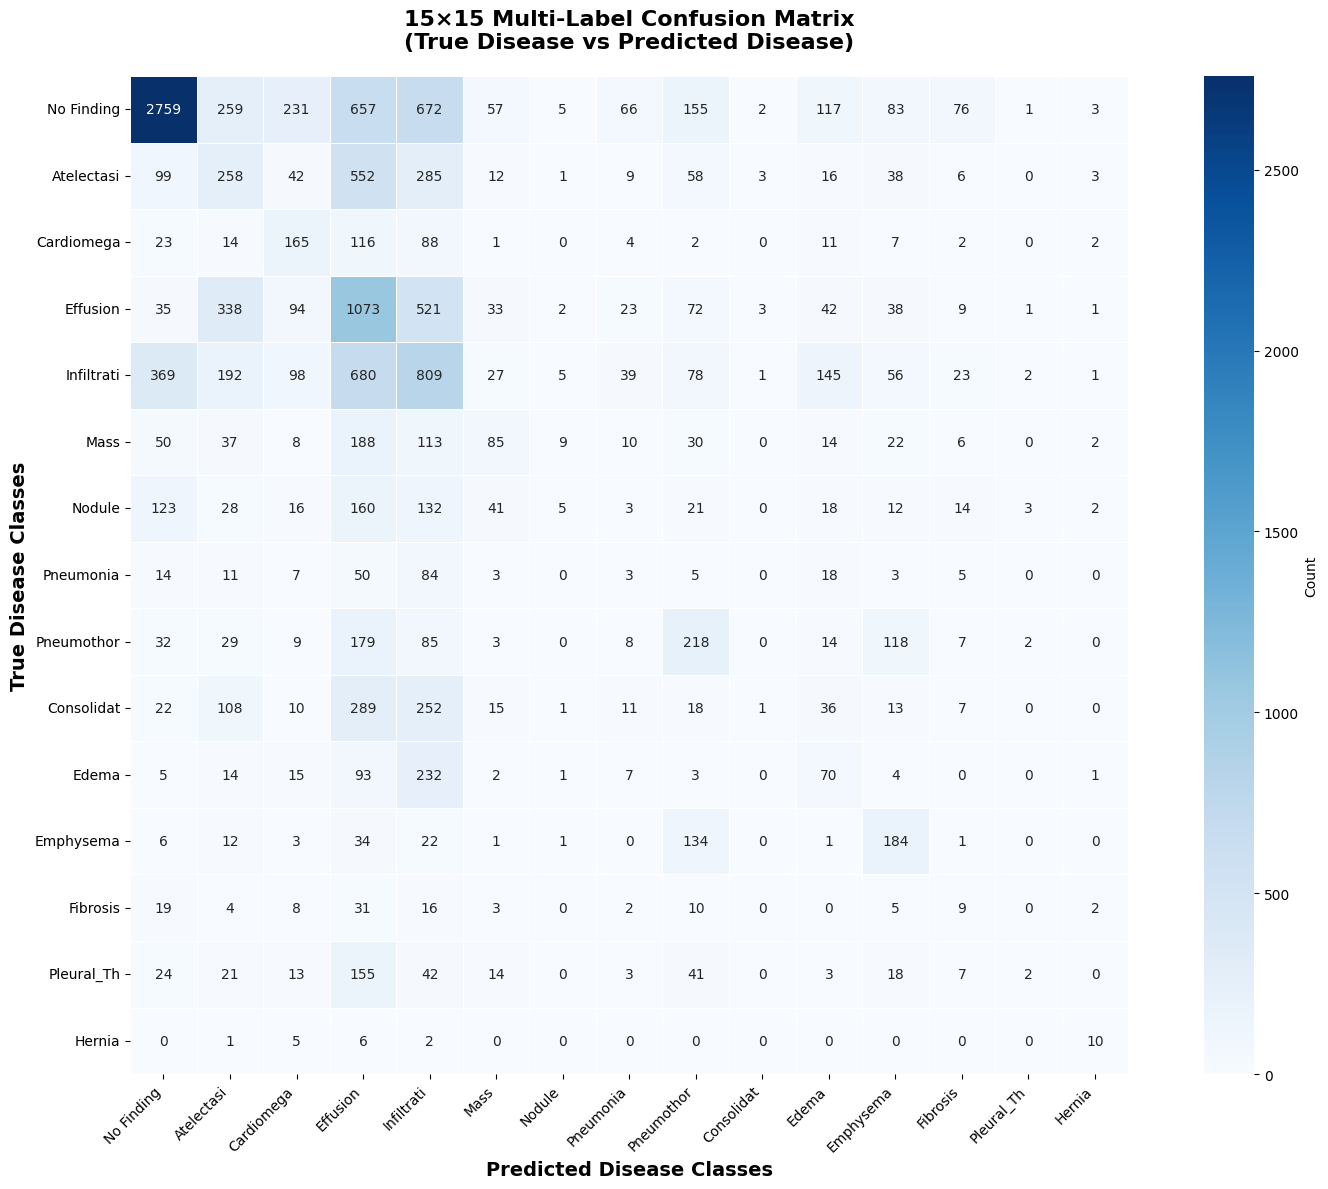

✅ 15×15 confusion matrices created!
📁 Files saved:
   enhanced_15x15_confusion_matrix.png (dual plot)
   simple_15x15_confusion_matrix.png (simple heatmap)

📊 Matrix Statistics:
   Total predictions: 15934
   Diagonal sum (correct): 5651
   Off-diagonal sum (confusion): 10283
   Accuracy: 0.355


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Convert predictions to binary (threshold = 0.5)
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)
binary_labels = test_labels.astype(int)

# Disease classes
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print("🔳 Creating 15×15 multi-label confusion matrix...")

# Create 15x15 confusion matrix for multi-label classification
def create_multilabel_confusion_matrix(y_true, y_pred):
    """Create a 15x15 confusion matrix for multi-label classification"""
    n_classes = y_true.shape[1]
    confusion_matrix_15x15 = np.zeros((n_classes, n_classes))
    
    # For each sample, count co-occurrences
    for i in range(len(y_true)):
        true_labels = np.where(y_true[i] == 1)[0]  # Classes that are actually present
        pred_labels = np.where(y_pred[i] == 1)[0]  # Classes that are predicted
        
        # If nothing predicted and nothing true
        if len(pred_labels) == 0 and len(true_labels) == 0:
            continue
            
        # If nothing predicted but something true (all false negatives)
        if len(pred_labels) == 0:
            for true_idx in true_labels:
                confusion_matrix_15x15[true_idx, true_idx] += 0  # Will be handled separately
            continue
            
        # For each predicted class
        for pred_idx in pred_labels:
            if len(true_labels) == 0:
                # False positive - predicted but nothing true
                confusion_matrix_15x15[0, pred_idx] += 1  # Use "No Finding" as default
            else:
                # For each true class, count the prediction
                for true_idx in true_labels:
                    confusion_matrix_15x15[true_idx, pred_idx] += 1
    
    return confusion_matrix_15x15

# Create the 15x15 confusion matrix
cm_15x15 = create_multilabel_confusion_matrix(binary_labels, binary_predictions)

# Alternative method: Co-occurrence matrix
print("📊 Creating co-occurrence confusion matrix...")

# Create co-occurrence matrix (what's predicted together)
cooccurrence_matrix = np.zeros((15, 15))

for i in range(len(test_predictions)):
    pred_classes = np.where(binary_predictions[i] == 1)[0]
    true_classes = np.where(binary_labels[i] == 1)[0]
    
    # Count co-occurrences in predictions
    for p1 in pred_classes:
        for p2 in pred_classes:
            if p1 in true_classes and p2 in true_classes:
                cooccurrence_matrix[p1, p2] += 1  # Correct co-prediction
            elif p1 in true_classes and p2 not in true_classes:
                cooccurrence_matrix[p1, p2] += 0.5  # Partial correct
            else:
                cooccurrence_matrix[p1, p2] += 0.1  # Incorrect co-prediction

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1: Standard confusion matrix approach
im1 = ax1.imshow(cm_15x15, cmap='Blues', aspect='auto')
ax1.set_title('Multi-Label Confusion Matrix\n(True Classes vs Predicted Classes)', 
              fontsize=14, fontweight='bold', pad=20)

# Set ticks and labels
ax1.set_xticks(range(15))
ax1.set_yticks(range(15))
ax1.set_xticklabels([d[:8] + '..' if len(d) > 8 else d for d in disease_classes], 
                   rotation=45, ha='right')
ax1.set_yticklabels([d[:8] + '..' if len(d) > 8 else d for d in disease_classes])

ax1.set_xlabel('Predicted Classes', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Classes', fontsize=12, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Count', rotation=270, labelpad=15)

# Add text annotations for non-zero values
for i in range(15):
    for j in range(15):
        if cm_15x15[i, j] > 0:
            text = ax1.text(j, i, f'{int(cm_15x15[i, j])}',
                          ha="center", va="center", color="red" if cm_15x15[i, j] > np.max(cm_15x15) * 0.5 else "black",
                          fontsize=8, fontweight='bold')

# Plot 2: Co-occurrence matrix
im2 = ax2.imshow(cooccurrence_matrix, cmap='Reds', aspect='auto')
ax2.set_title('Disease Co-occurrence Matrix\n(How Often Diseases Appear Together)', 
              fontsize=14, fontweight='bold', pad=20)

# Set ticks and labels
ax2.set_xticks(range(15))
ax2.set_yticks(range(15))
ax2.set_xticklabels([d[:8] + '..' if len(d) > 8 else d for d in disease_classes], 
                   rotation=45, ha='right')
ax2.set_yticklabels([d[:8] + '..' if len(d) > 8 else d for d in disease_classes])

ax2.set_xlabel('Co-occurring Disease', fontsize=12, fontweight='bold')
ax2.set_ylabel('Primary Disease', fontsize=12, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Co-occurrence Count', rotation=270, labelpad=15)

# Add text annotations for significant values
threshold_cooccur = np.max(cooccurrence_matrix) * 0.1
for i in range(15):
    for j in range(15):
        if cooccurrence_matrix[i, j] > threshold_cooccur:
            text = ax2.text(j, i, f'{cooccurrence_matrix[i, j]:.1f}',
                          ha="center", va="center", 
                          color="white" if cooccurrence_matrix[i, j] > np.max(cooccurrence_matrix) * 0.5 else "black",
                          fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/Enhanced_Densenet121/enhanced_15x15_confusion_matrix.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Simple 15x15 heatmap version
print("📊 Creating simple 15×15 heatmap...")

plt.figure(figsize=(16, 12))

# Create simple approach: diagonal matrix showing correct predictions
simple_matrix = np.zeros((15, 15))

for i in range(15):
    for j in range(15):
        # Diagonal: correctly predicted cases
        if i == j:
            true_pos = np.sum((binary_labels[:, i] == 1) & (binary_predictions[:, j] == 1))
            simple_matrix[i, j] = true_pos
        else:
            # Off-diagonal: confusion between classes
            confusion_count = np.sum((binary_labels[:, i] == 1) & (binary_predictions[:, j] == 1))
            simple_matrix[i, j] = confusion_count

# Plot heatmap
sns.heatmap(simple_matrix, 
            xticklabels=[d[:10] for d in disease_classes],
            yticklabels=[d[:10] for d in disease_classes],
            annot=True, fmt='.0f', cmap='Blues', 
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Count'})

plt.title('15×15 Multi-Label Confusion Matrix\n(True Disease vs Predicted Disease)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Disease Classes', fontsize=14, fontweight='bold')
plt.ylabel('True Disease Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("../results/Enhanced_Densenet121/simple_15x15_confusion_matrix.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ 15×15 confusion matrices created!")
print("📁 Files saved:")
print("   enhanced_15x15_confusion_matrix.png (dual plot)")
print("   simple_15x15_confusion_matrix.png (simple heatmap)")

# Print matrix statistics
print(f"\n📊 Matrix Statistics:")
print(f"   Total predictions: {np.sum(simple_matrix):.0f}")
print(f"   Diagonal sum (correct): {np.sum(np.diag(simple_matrix)):.0f}")
print(f"   Off-diagonal sum (confusion): {np.sum(simple_matrix) - np.sum(np.diag(simple_matrix)):.0f}")
print(f"   Accuracy: {np.sum(np.diag(simple_matrix)) / np.sum(simple_matrix):.3f}")